In [1]:
import pandas.io.sql as psql
import json
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit import rdBase
from rdkit import DataStructs
#import psycopg2 as pg


import pandas as pd
import sqlalchemy as db
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from pandas import concat

from collections import OrderedDict
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

import cheminformatics.utils.multicore as multicore
import time
import math
from multiprocessing import Pool,Queue, Process, cpu_count
import os
import sys

import chemfp
from chemfp import search

import numpy as np

import random
from numpy import median 
from itertools import combinations

from rdkit.Chem import QED 

# read core info

In [2]:
pool = pd.read_csv("../03_target_pred/Results/pcc_plus_with_targets.csv",encoding='utf-8')

In [3]:
print(pool.shape)
pool.head()

(2996705, 4)


Unnamed: 0  query_index                   query_smiles  \
0           0         9812   C1CCCC(N2CCN(C3CCCC3)CC2)CC1   
1           1        13121   C1CCC(N2CCN(C3CCCCC3)CC2)CC1   
2           2         9438  C1CCCC(N2CCC(N3CCCCC3)CC2)CC1   
3           3        12848   C1CCC(N2CCC(N3CCCCC3)CC2)CC1   
4           4        12853  C1CCC(N2CCC(N3CCCCCC3)CC2)CC1   

                   targets  
0  {CHEMBL4153,CHEMBL5525}  
1  {CHEMBL4153,CHEMBL5525}  
2  {CHEMBL4153,CHEMBL5525}  
3  {CHEMBL4153,CHEMBL5525}  
4  {CHEMBL4153,CHEMBL5525}

In [4]:
pool.tail()

Unnamed: 0  query_index  \
2996700     2996700      2889115   
2996701     2996701      2889116   
2996702     2996702      2889117   
2996703     2996703      2889118   
2996704     2996704      2832188   

                                              query_smiles targets  
2996700  O=C(N[C@@H](c1ccccn1)[C@@H]1CCCN(CC2=CCCOC2)C1...          
2996701  O=C(N[C@@H](c1ccccn1)[C@H]1CCCN(CC2=CCCOC2)C1)...          
2996702  O=C(N[C@H](c1ccccn1)[C@@H]1CCCN(CC2=CCCOC2)C1)...          
2996703  O=C(N[C@H](c1ccccn1)[C@H]1CCCN(CC2=CCCOC2)C1)c...          
2996704  O=C(NCCc1cccc(Cl)c1)[C@@H]1C[C@@H](n2cnnn2)CN1...

In [5]:
targets_novelty_scores = pd.read_csv("../01_chembl_data_prep/Results/targets_with_novelty_scores.csv",encoding='utf-8')

In [6]:
targets_novelty_scores.head()

target_chembl_id   clan     pfam  clan_novelty_score  pfam_novelty_score  \
0    CHEMBL1075021   c519  PF00204            0.880137            0.813719   
1    CHEMBL1075022   c637  PF00204            0.166667            0.813719   
2    CHEMBL1075023  c1484  PF01048            0.000000            0.269437   
3    CHEMBL1075024   c582  PF03060            0.250000            0.250000   
4    CHEMBL1075025  c1864  PF01255            0.000000            0.000000   

   in_actives  in_predicted  
0           1             0  
1           1             0  
2           1             1  
3           1             1  
4           1             1

In [7]:
clusters = pd.read_csv("../02_zinc15_data_prep/Results/parsed_clusers_04.csv")
clusters['cluster_id'] = np.where((clusters.cluster_id == 'false_singleton'),clusters.member,clusters.member)
clusters.head()

/Home/ii/neannm/anaconda3/envs/rdkit3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cluster_id   member
0     1000192  1000192
1     1000844  1000844
2     1001115  1001115
3     1001430  1001430
4     1001929  1001929

# novel7_elitist_pfam_novelty_parallel_1k_100_1_pcc_plus

## fitness score evolution

In [8]:
evolution_scores = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_1k_100_1_pcc_plus/result_novel7_elitist_pfam_novelty_parallel_1k_100_1_pcc_plus.csv",encoding='utf-8')

In [9]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [10]:
print(evolution_scores.shape)
evolution_scores.head()

(100, 3)


fitness  generation   use
0  0.459636           0  True
1  0.516044           0  True
2  0.444128           0  True
3  0.480074           0  True
4  0.477158           0  True

In [11]:
evolution_scores.tail()

fitness  generation   use
95  0.499931           0  True
96  0.471773           0  True
97  0.515268           0  True
98  0.469719           0  True
99  0.495626           0  True

In [12]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.459636           0  True
1  0.516044           0  True
2  0.444128           0  True
3  0.480074           0  True
4  0.477158           0  True

In [13]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


Text(0, 0.5, 'fitness')

In [14]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation  fitness   use
0           0  0.54064  True

<AxesSubplot:xlabel='generation', ylabel='fitness'>

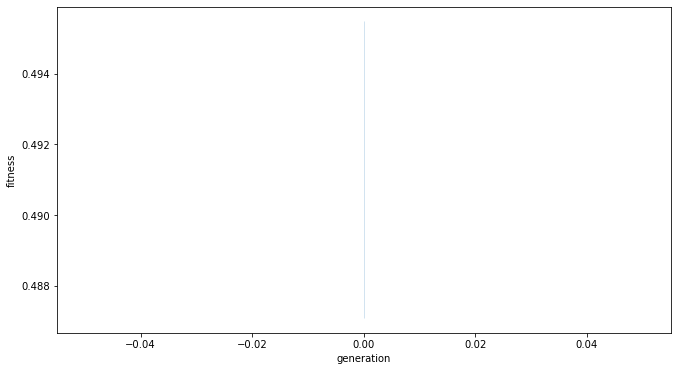

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

(array([0.6 , 0.65, 0.7 , 0.75]),
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

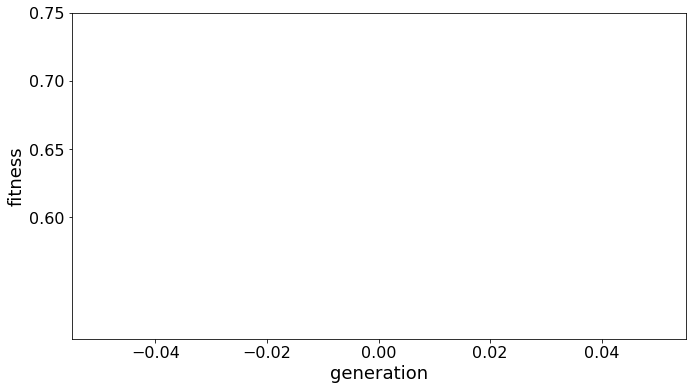

In [16]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.6,0.75, .05))
plt.yticks(fontsize=16)

In [17]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.5406401269405819
max overall: 0.5406401269405819
improvement: 0.0


## population scaffold change

In [18]:
best_pop_at_0 = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_1k_100_1_pcc_plus/best_chromo_novel7_elitist_pfam_novelty_parallel_1k_100_1_pcc_plus_0.csv",encoding='utf-8',names=['file_index'])

In [19]:
print(len(best_pop_at_0))


1000


In [20]:
best_pop_at_0.head()

file_index
0    284293.0
1    500633.0
2    132040.0
3   1956193.0
4     48458.0

In [21]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  Unnamed: 0  query_index  \
0    284293.0      284293        58080   
1    500633.0      500633      1733129   
2    132040.0      132040      2020840   
3   1956193.0     1956193       669413   
4     48458.0       48458        17522   

                                       query_smiles          targets  
0  Cc1c(C)c2ccc(OCC(=O)N3CCN(Cc4ccccc4)CC3)cc2oc1=O     {CHEMBL4158}  
1  CN(CC(=O)Nc1ccccc1C(F)(F)F)S(=O)(=O)c1ccc(Cl)cc1  {CHEMBL1293238}  
2           COc1ccc(/N=C/c2ccc(N3CCOCC3)cc2OC)cc1Cl  {CHEMBL1075257}  
3        Cc1nonc1CC(=O)N1CCO[C@@](CO)(Cc2ccccc2F)C1                   
4                c1cncc(-c2nnc(-c3csc4c3CCCC4)o2)c1  {CHEMBL1293277}

In [22]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [23]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()



print("max at 0:",max_at_0)


max at 0: 950


## cluster representation change

In [24]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")


file_index  Unnamed: 0  query_index  \
0    284293.0      284293        58080   
1    500633.0      500633      1733129   
2    132040.0      132040      2020840   
3   1956193.0     1956193       669413   
4     48458.0       48458        17522   

                                       query_smiles          targets  \
0  Cc1c(C)c2ccc(OCC(=O)N3CCN(Cc4ccccc4)CC3)cc2oc1=O     {CHEMBL4158}   
1  CN(CC(=O)Nc1ccccc1C(F)(F)F)S(=O)(=O)c1ccc(Cl)cc1  {CHEMBL1293238}   
2           COc1ccc(/N=C/c2ccc(N3CCOCC3)cc2OC)cc1Cl  {CHEMBL1075257}   
3        Cc1nonc1CC(=O)N1CCO[C@@](CO)(Cc2ccccc2F)C1                    
4                c1cncc(-c2nnc(-c3csc4c3CCCC4)o2)c1  {CHEMBL1293277}   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                  murcko_smiles  cluster_id     member  
0  O=C(COc1ccc2ccc(=O)oc2c1)N1CCN(Cc2ccccc2)CC1     58080.0    58080.0  
1             O=C(CNS(=O)(=O)c1ccccc1)Nc1ccccc1   1733129.0  1733129.0  
2             C(=N/c1ccccc1)\c1ccc(N2CCOCC2)cc1   2020840.0  2020840.0  
3              O=C(Cc1cnon1)N1CCOC(Cc2ccccc2)C1         NaN        NaN  
4            c1cncc(-c2nnc(-c3csc4c3CCCC4)o2)c1     17522.0    17522.0
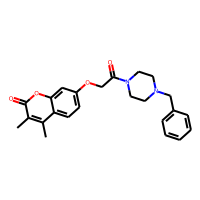
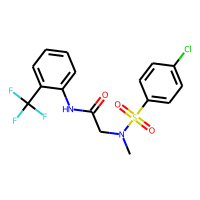
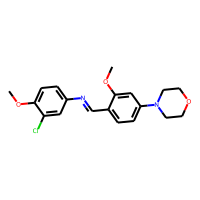
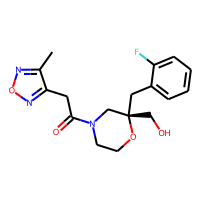
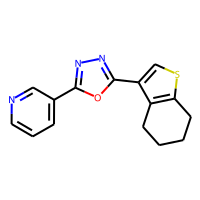

In [25]:
best_pop_at_0.head()

In [26]:
max_at_0 = best_pop_at_0['member'].nunique()
print("max at 0:",max_at_0)


max at 0: 500


## target profile changes

#### number of targets

In [27]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)
targets_for_0.replace(" ", float("NaN"), inplace=True)
targets_for_0.dropna(inplace=True)

print("number of bioactivites", targets_for_0.shape)

(1346, 1)
number of bioactivites (846, 1)


In [28]:

targets_for_0.drop_duplicates(inplace = True)
print("number of unique_targets", targets_for_0.shape)

number of unique_targets (266, 1)


#### number of pfams

In [29]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")



In [30]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0     CHEMBL4158       CHEMBL4158   c125  PF00698            0.976540   
1  CHEMBL1293238    CHEMBL1293238   c780  PF00459            0.000671   
2  CHEMBL1075257    CHEMBL1075257  c2103  PF06431            0.982222   
3  CHEMBL1293277    CHEMBL1293277  c3016  PF16414            1.000000   
4     CHEMBL2026       CHEMBL2026    c71  PF00144            0.883195   

   pfam_novelty_score  in_actives  in_predicted  
0            0.983670           1             1  
1            0.000671           1             1  
2            0.982222           1             1  
3            0.995817           1             1  
4            0.927981           1             1

In [31]:
print(targets_for_0.shape)


(274, 8)


In [32]:


max_at_0 = targets_for_0['pfam'].nunique()

print("max at 0:",max_at_0)


max at 0: 138


### change in median novelty score

In [33]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
print("max at 0:",max_at_0)

max at 0: 0.74053072704576


# novel7_elitist_pfam_novelty_parallel_5k_500_300_0randoms

## fitness score evolution

In [34]:
evolution_scores = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_500_1_pcc_plus/result_novel7_elitist_pfam_novelty_parallel_5k_500_1_pcc_plus.csv",encoding='utf-8')

In [35]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [36]:
print(evolution_scores.shape)
evolution_scores.head()

(500, 3)


fitness  generation   use
0  0.374793           0  True
1  0.379211           0  True
2  0.376309           0  True
3  0.363928           0  True
4  0.365783           0  True

In [37]:
evolution_scores.tail()

fitness  generation   use
495  0.376006           0  True
496  0.379348           0  True
497  0.357711           0  True
498  0.362016           0  True
499  0.368260           0  True

In [38]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.374793           0  True
1  0.379211           0  True
2  0.376309           0  True
3  0.363928           0  True
4  0.365783           0  True

Text(0, 0.5, 'fitness')

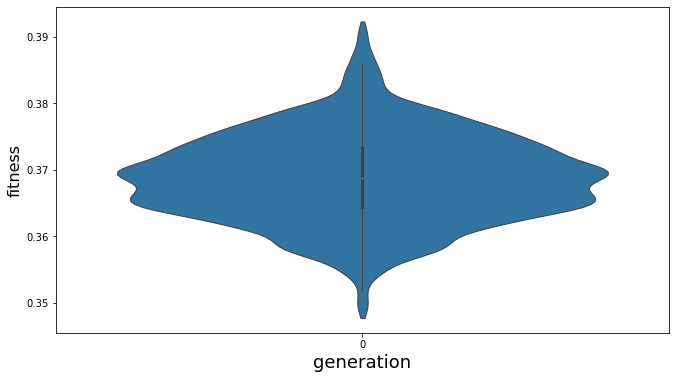

In [39]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [40]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness   use
0           0  0.390976  True

<AxesSubplot:xlabel='generation', ylabel='fitness'>

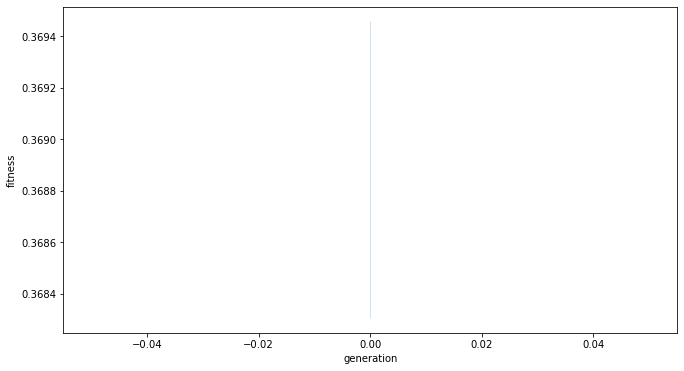

In [41]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

Text(0, 0.5, 'fitness')

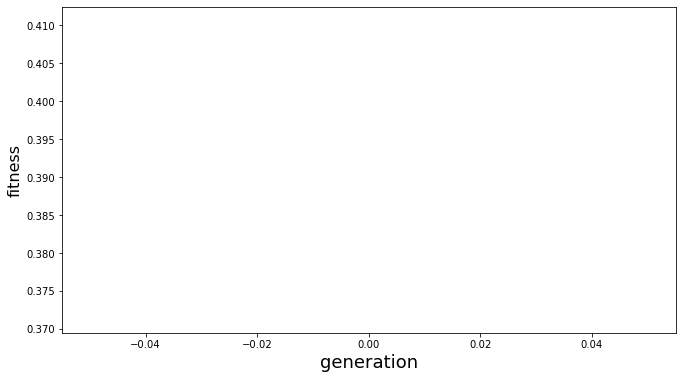

In [42]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [43]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.3909764470927648
max overall: 0.3909764470927648
improvement: 0.0


## population scaffold change

In [44]:
best_pop_at_0 = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_5k_1000_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [45]:
print(len(best_pop_at_0))


5000


In [46]:
best_pop_at_0.head()

file_index
0    416549.0
1    855195.0
2     97480.0
3   1234380.0
4    616767.0

In [47]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  Unnamed: 0  query_index  \
0    416549.0      416549       874367   
1    855195.0      855195      2808479   
2     97480.0       97480        94652   
3   1234380.0     1234380      1595332   
4    616767.0      616767      1621391   

                                        query_smiles          targets  
0   CCCCOc1ccc(C(=O)N2CCN(c3cc(-n4ccnc4)ncn3)CC2)cc1  {CHEMBL1293255}  
1             O=C(NCc1cccc(OC(F)(F)F)c1)[C@@H]1CCOC1     {CHEMBL6110}  
2           C=c1ccc(=c2[nH]/c(=C\c3cccs3)c(=O)o2)cc1     {CHEMBL5567}  
3  Cn1cc(S(=O)(=O)N2CCN(CC(=O)Nc3ccc(OC(F)F)cc3)C...      {CHEMBL340}  
4  Cn1c(Sc2ccc(C3OC(=O)CC(=O)O3)cc2[N+](=O)[O-])n...     {CHEMBL3024}

In [48]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [49]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()



print("max at 0:",max_at_0)


max at 0: 4114


## cluster representation change

In [50]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")


file_index  Unnamed: 0  query_index  \
0    416549.0      416549       874367   
1    855195.0      855195      2808479   
2     97480.0       97480        94652   
3   1234380.0     1234380      1595332   
4    616767.0      616767      1621391   

                                        query_smiles          targets  \
0   CCCCOc1ccc(C(=O)N2CCN(c3cc(-n4ccnc4)ncn3)CC2)cc1  {CHEMBL1293255}   
1             O=C(NCc1cccc(OC(F)(F)F)c1)[C@@H]1CCOC1     {CHEMBL6110}   
2           C=c1ccc(=c2[nH]/c(=C\c3cccs3)c(=O)o2)cc1     {CHEMBL5567}   
3  Cn1cc(S(=O)(=O)N2CCN(CC(=O)Nc3ccc(OC(F)F)cc3)C...      {CHEMBL340}   
4  Cn1c(Sc2ccc(C3OC(=O)CC(=O)O3)cc2[N+](=O)[O-])n...     {CHEMBL3024}   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                      murcko_smiles  cluster_id   member  
0         O=C(c1ccccc1)N1CCN(c2cc(-n3ccnc3)ncn2)CC1      874367   874367  
1                       O=C(NCc1ccccc1)[C@@H]1CCOC1     2808479  2808479  
2          C=c1ccc(=c2[nH]/c(=C\c3cccs3)c(=O)o2)cc1       94652    94652  
3      O=C(CN1CCN(S(=O)(=O)c2cn[nH]c2)CC1)Nc1ccccc1     1595332  1595332  
4  O=C1CC(=O)OC(c2ccc(Sc3nnc(-c4ccccc4)[nH]3)cc2)O1     1621391  1621391
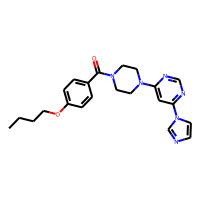
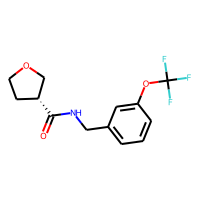
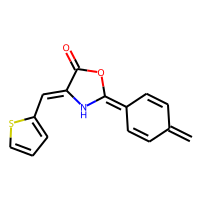
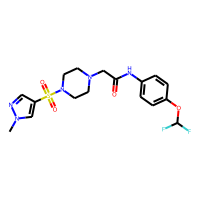
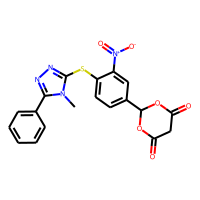

In [51]:
best_pop_at_0.head()

In [52]:
max_at_0 = best_pop_at_0['member'].nunique()
print("max at 0:",max_at_0)


max at 0: 5000


## target profile changes

#### number of targets

In [53]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)
targets_for_0.replace(" ", float("NaN"), inplace=True)
targets_for_0.dropna(inplace=True)

print("number of bioactivites", targets_for_0.shape)

(8307, 1)
number of bioactivites (8307, 1)


In [54]:

targets_for_0.drop_duplicates(inplace = True)
print("number of unique_targets", targets_for_0.shape)

number of unique_targets (942, 1)


#### number of pfams

In [55]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")



In [56]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0  CHEMBL1293255    CHEMBL1293255  c1964  PF00106            1.000000   
1     CHEMBL6110       CHEMBL6110  c2281  PF07992            0.996305   
2     CHEMBL5567       CHEMBL5567   c249  PF00501            0.926807   
3      CHEMBL340        CHEMBL340    c48  PF00067            0.264734   
4     CHEMBL3024       CHEMBL3024   c552  PF00069            0.929847   

   pfam_novelty_score  in_actives  in_predicted  
0            0.634213           1             1  
1            0.961023           1             1  
2            0.917624           1             1  
3            0.398705           1             1  
4            0.757207           1             1

In [57]:
print(targets_for_0.shape)


(1012, 8)


In [58]:


max_at_0 = targets_for_0['pfam'].nunique()

print("max at 0:",max_at_0)


max at 0: 359


### change in median novelty score

In [59]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
print("max at 0:",max_at_0)

max at 0: 0.691573370651739


# novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms

## fitness score evolution

In [60]:
evolution_scores = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_10k_1000_1_pcc_plus/result_novel7_elitist_pfam_novelty_parallel_10k_1000_1_pcc_plus.csv",encoding='utf-8')

In [61]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [62]:
print(evolution_scores.shape)
evolution_scores.head()

(1000, 3)


fitness  generation   use
0  0.285296           0  True
1  0.291551           0  True
2  0.290426           0  True
3  0.287355           0  True
4  0.287865           0  True

In [63]:
evolution_scores.tail()

fitness  generation   use
995  0.288064           0  True
996  0.289713           0  True
997  0.285067           0  True
998  0.287955           0  True
999  0.289724           0  True

In [64]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.285296           0  True
1  0.291551           0  True
2  0.290426           0  True
3  0.287355           0  True
4  0.287865           0  True

Text(0, 0.5, 'fitness')

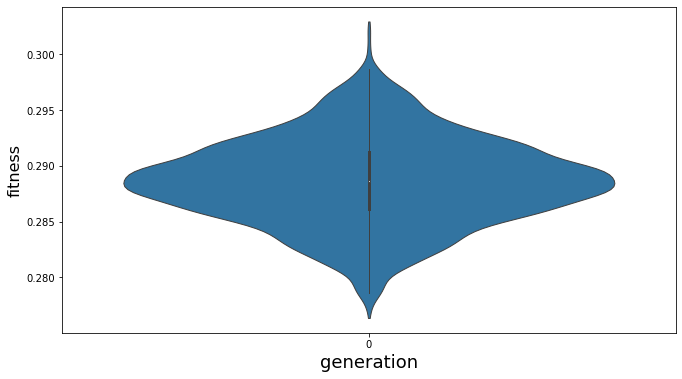

In [65]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [66]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness   use
0           0  0.302173  True

<AxesSubplot:xlabel='generation', ylabel='fitness'>

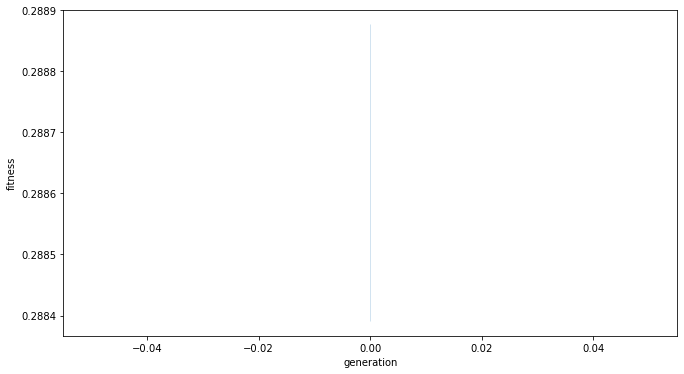

In [67]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

Text(0, 0.5, 'fitness')

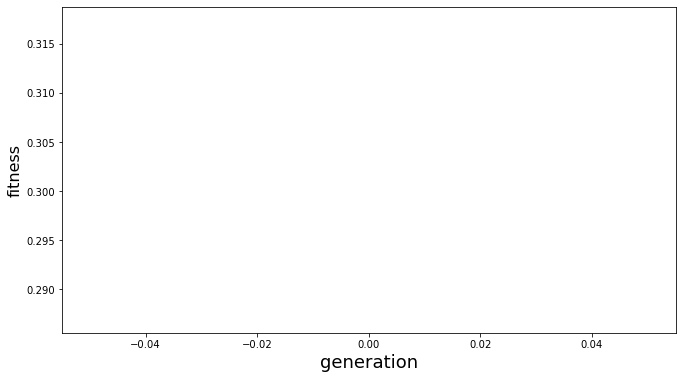

In [68]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [69]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.30217274259172583
max overall: 0.30217274259172583
improvement: 0.0


## population scaffold change

In [70]:
best_pop_at_0 = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_10k_1000_1_pcc_plus/best_chromo_novel7_elitist_pfam_novelty_parallel_10k_1000_1_pcc_plus_0.csv",encoding='utf-8',names=['file_index'])

In [71]:
print(len(best_pop_at_0))


10000


In [72]:
best_pop_at_0.head()

file_index
0    381097.0
1   2714154.0
2    338637.0
3    480869.0
4   2127288.0

In [73]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  Unnamed: 0  query_index  \
0    381097.0      381097      1437826   
1   2714154.0     2714154      2368522   
2    338637.0      338637      2092793   
3    480869.0      480869       689518   
4   2127288.0     2127288      1135102   

                                   query_smiles                     targets  
0  CC(=O)N1CCc2c(sc(NC(=O)c3ccccc3C)c2C(N)=O)C1                {CHEMBL1974}  
1        N#Cc1c(Cn2cnc3cc(F)ccc3c2=O)cn2ccccc12                              
2                COC1(CNC(=O)NCCc2ccccc2)CCSCC1  {CHEMBL1968,CHEMBL1075293}  
3  CCc1ccc2[nH]c(=O)c(CNc3ccc(NC(C)=O)cc3)cc2c1             {CHEMBL3988585}  
4  C[C@H](Cn1cccn1)OC(=O)c1cccc([N+](=O)[O-])c1

In [74]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [75]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()



print("max at 0:",max_at_0)


max at 0: 8700


## cluster representation change

In [76]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")


file_index  Unnamed: 0  query_index  \
0    381097.0      381097      1437826   
1   2714154.0     2714154      2368522   
2    338637.0      338637      2092793   
3    480869.0      480869       689518   
4   2127288.0     2127288      1135102   

                                   query_smiles                     targets  \
0  CC(=O)N1CCc2c(sc(NC(=O)c3ccccc3C)c2C(N)=O)C1                {CHEMBL1974}   
1        N#Cc1c(Cn2cnc3cc(F)ccc3c2=O)cn2ccccc12                               
2                COC1(CNC(=O)NCCc2ccccc2)CCSCC1  {CHEMBL1968,CHEMBL1075293}   
3  CCc1ccc2[nH]c(=O)c(CNc3ccc(NC(C)=O)cc3)cc2c1             {CHEMBL3988585}   
4  C[C@H](Cn1cccn1)OC(=O)c1cccc([N+](=O)[O-])c1                               

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                    murcko_smiles  cluster_id     member  
0   O=C(Nc1cc2c(s1)CNCC2)c1ccccc1   1437826.0  1437826.0  
1  O=c1c2ccccc2ncn1Cc1cc2ccccn2c1         NaN        NaN  
2      O=C(NCCc1ccccc1)NCC1CCSCC1   2092793.0  2092793.0  
3   O=c1[nH]c2ccccc2cc1CNc1ccccc1    689518.0   689518.0  
4         O=C(OCCn1cccn1)c1ccccc1         NaN        NaN
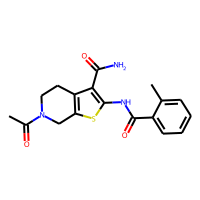
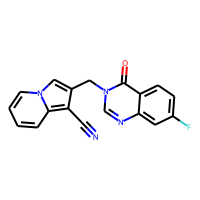
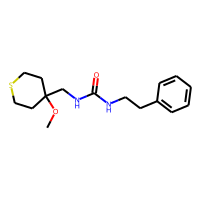
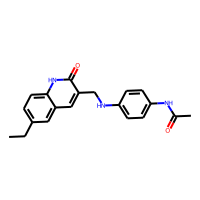

In [77]:
best_pop_at_0.head()

In [78]:
max_at_0 = best_pop_at_0['member'].nunique()
print("max at 0:",max_at_0)


max at 0: 4894


## target profile changes

#### number of targets

In [79]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)
targets_for_0.replace(" ", float("NaN"), inplace=True)
targets_for_0.dropna(inplace=True)

print("number of bioactivites", targets_for_0.shape)

(13069, 1)
number of bioactivites (7963, 1)


In [80]:

targets_for_0.drop_duplicates(inplace = True)
print("number of unique_targets", targets_for_0.shape)

number of unique_targets (867, 1)


#### number of pfams

In [81]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")



In [82]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0     CHEMBL1974       CHEMBL1974  c1078  PF07714            0.859896   
1     CHEMBL1968       CHEMBL1968   c608  PF00561            0.988930   
2  CHEMBL1075293    CHEMBL1075293   c608  PF06441            0.988930   
3  CHEMBL3988585    CHEMBL3988585  c2710  PF07992            1.000000   
4  CHEMBL1293303    CHEMBL1293303  c1477  PF00600            1.000000   

   pfam_novelty_score  in_actives  in_predicted  
0            0.750297           1             1  
1            0.676848           1             1  
2            1.000000           1             1  
3            0.961023           1             1  
4            1.000000           1             1

In [83]:
print(targets_for_0.shape)


(1009, 8)


In [84]:


max_at_0 = targets_for_0['pfam'].nunique()

print("max at 0:",max_at_0)


max at 0: 420


### change in median novelty score

In [85]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
print("max at 0:",max_at_0)

max at 0: 0.740620459789761


# novel7_elitist_pfam_novelty_parallel_15k_1500_300_0randoms

## fitness score evolution

In [86]:
evolution_scores = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_15k_1500_1_pcc_plus/result_novel7_elitist_pfam_novelty_parallel_15k_1500_1_pcc_plus.csv",encoding='utf-8')

In [87]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [88]:
print(evolution_scores.shape)
evolution_scores.head()

(1500, 3)


fitness  generation   use
0  0.249978           0  True
1  0.242815           0  True
2  0.243949           0  True
3  0.241961           0  True
4  0.239874           0  True

In [89]:
evolution_scores.tail()

fitness  generation   use
1495  0.242668           0  True
1496  0.244043           0  True
1497  0.248559           0  True
1498  0.242491           0  True
1499  0.239517           0  True

In [90]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.249978           0  True
1  0.242815           0  True
2  0.243949           0  True
3  0.241961           0  True
4  0.239874           0  True

Text(0, 0.5, 'fitness')

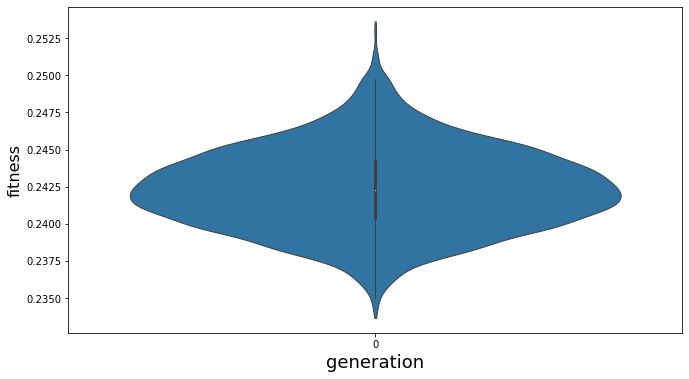

In [91]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [92]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness   use
0           0  0.253074  True

<AxesSubplot:xlabel='generation', ylabel='fitness'>

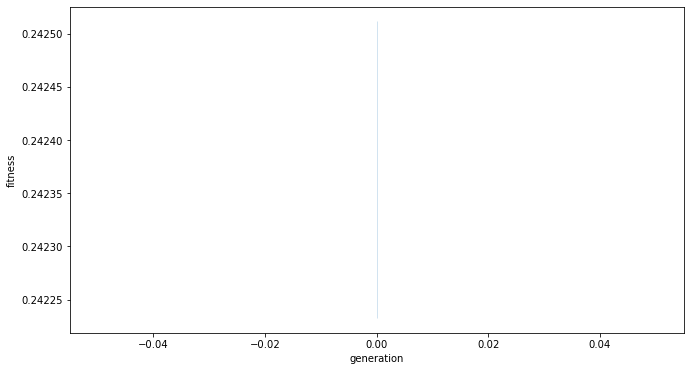

In [93]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

In [94]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

Text(0, 0.5, 'fitness')

In [95]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.25307367910404194
max overall: 0.25307367910404194
improvement: 0.0


## population scaffold change

In [96]:
best_pop_at_0 = pd.read_csv("Results/novel7_elitist_pfam_novelty_parallel_15k_1500_1_pcc_plus/best_chromo_novel7_elitist_pfam_novelty_parallel_15k_1500_1_pcc_plus_0.csv",encoding='utf-8',names=['file_index'])

In [97]:
print(len(best_pop_at_0))


15000


In [98]:
best_pop_at_0.head()

file_index
0   2787152.0
1   1889624.0
2   2162262.0
3   2983629.0
4     33564.0

In [99]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  Unnamed: 0  query_index  \
0   2787152.0     2787152      2992232   
1   1889624.0     1889624       827624   
2   2162262.0     2162262      1319816   
3   2983629.0     2983629      2868467   
4     33564.0       33564      2983339   

                                        query_smiles  \
0                    O=S(=O)(Nn1cccn1)c1cccc2ccccc12   
1  CC(C)(C)C(=O)N1CC[C@@H](Cc2cccc(-c3ccc(C(=O)O)...   
2           CC(=O)c1cccc(-n2cnnc2CCc2c(C)n[nH]c2C)c1   
3  O=C(NCCN1C(=O)S/C(=C\c2ccc(Cl)cc2)C1=O)c1[nH]n...   
4        O=S(=O)(Nc1ccc(F)cc1)c1ccc(-c2ccc(CO)o2)cc1   

                                             targets  
0                                                     
1                                                     
2                                                     
3                                                     
4  {CHEMBL2406894,CHEMBL281,CHEMBL261,CHEMBL2283,...

In [100]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [101]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()



print("max at 0:",max_at_0)


max at 0: 12716


## cluster representation change

In [102]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")


file_index  Unnamed: 0  query_index  \
0   2787152.0     2787152      2992232   
1   1889624.0     1889624       827624   
2   2162262.0     2162262      1319816   
3   2983629.0     2983629      2868467   
4     33564.0       33564      2983339   

                                        query_smiles  \
0                    O=S(=O)(Nn1cccn1)c1cccc2ccccc12   
1  CC(C)(C)C(=O)N1CC[C@@H](Cc2cccc(-c3ccc(C(=O)O)...   
2           CC(=O)c1cccc(-n2cnnc2CCc2c(C)n[nH]c2C)c1   
3  O=C(NCCN1C(=O)S/C(=C\c2ccc(Cl)cc2)C1=O)c1[nH]n...   
4        O=S(=O)(Nc1ccc(F)cc1)c1ccc(-c2ccc(CO)o2)cc1   

                                             targets  \
0                                                      
1                                                      
2                                                      
3                                                      
4  {CHEMBL2406894,CHEMBL281,CHEMBL261,CHEMBL2283,...   

                                            molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   
3  <img data-content="rdkit/molecule" src="data:i...   
4  <img data-content="rdkit/molecule" src="data:i...   

                                       murcko_smiles  cluster_id     member  
0                    O=S(=O)(Nn1cccn1)c1cccc2ccccc12         NaN        NaN  
1                 c1ccc(-c2cccc(C[C@@H]3CCNC3)n2)cc1         NaN        NaN  
2                     c1ccc(-n2cnnc2CCc2cn[nH]c2)cc1         NaN        NaN  
3  O=C(NCCN1C(=O)S/C(=C\c2ccccc2)C1=O)c1[nH]nc2cc...         NaN        NaN  
4               O=S(=O)(Nc1ccccc1)c1ccc(-c2ccco2)cc1   2983339.0  2983339.0
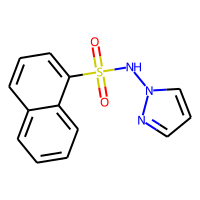
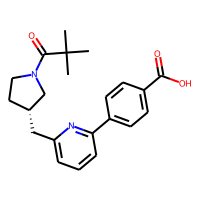
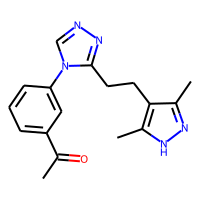
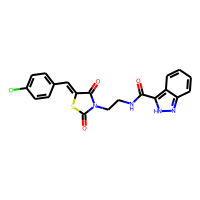
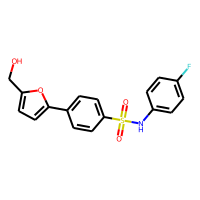

In [103]:
best_pop_at_0.head()

In [104]:
max_at_0 = best_pop_at_0['member'].nunique()
print("max at 0:",max_at_0)


max at 0: 7203


## target profile changes

#### number of targets

In [105]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)
targets_for_0.replace(" ", float("NaN"), inplace=True)
targets_for_0.dropna(inplace=True)

print("number of bioactivites", targets_for_0.shape)

(19732, 1)
number of bioactivites (11935, 1)


In [106]:

targets_for_0.drop_duplicates(inplace = True)
print("number of unique_targets", targets_for_0.shape)

number of unique_targets (1086, 1)


#### number of pfams

In [107]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")



In [108]:
targets_for_0.head()

targets target_chembl_id  clan     pfam  clan_novelty_score  \
0  CHEMBL2406894    CHEMBL2406894  c407  PF00245            0.854482   
1      CHEMBL281        CHEMBL281  c725  PF00194            0.318865   
2      CHEMBL261        CHEMBL261   c65  PF00194            0.618650   
3     CHEMBL2283       CHEMBL2283   c65  PF00194            0.618650   
4     CHEMBL5695       CHEMBL5695   c63  PF00245            0.778980   

   pfam_novelty_score  in_actives  in_predicted  
0            0.804303           1             1  
1            0.691573           1             1  
2            0.691573           1             1  
3            0.691573           1             1  
4            0.804303           1             1

In [109]:
print(targets_for_0.shape)


(1254, 8)


In [110]:


max_at_0 = targets_for_0['pfam'].nunique()

print("max at 0:",max_at_0)


max at 0: 460


### change in median novelty score

In [111]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
print("max at 0:",max_at_0)

max at 0: 0.7470101139203964
